In [1]:
import os
import warnings
from functools import partialmethod

import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from tools.chi2_functions import (get_fiducial_gaussian_chi2, get_hl_chi2,
                                  get_ideal_ptep_chi2, get_lollipop_chi2,
                                  get_offset_hl_chi2)
from tools.common_functions import (compute_offsets,
                                    compute_theoretical_spectrum)

In [2]:
tqdm.__init__ = partialmethod(tqdm.__init__, colour="green", ncols=120)
warnings.filterwarnings("ignore")

plt.rc("axes", labelsize=20, linewidth=1.5)
plt.rc("xtick", direction="in", labelsize=15, top=True)
plt.rc("ytick", direction="in", labelsize=15, right=True)

plt.rc("xtick.major", width=1.1, size=5)
plt.rc("ytick.major", width=1.1, size=5)

plt.rc("xtick.minor", width=1.1, size=3)
plt.rc("ytick.minor", width=1.1, size=3)

plt.rc("lines", linewidth=2)
plt.rc("legend", frameon=False, fontsize=15)
plt.rc("figure", dpi=100, autolayout=True, figsize=[10, 7])
plt.rc("savefig", dpi=150, bbox="tight")

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["red", "dodgerblue", "forestgreen", "goldenrod", "maroon", "cyan", "limegreen", "darkorange", "darkmagenta"])

In [3]:
N_sims = 1000

fsky = 40
nside = 16
npix = hp.nside2npix(nside)

fwhm = 1.33333 # beam in [deg] (this corresponds to 80 arcmin beam)
spec = ["EE", "BB"]

lmax = 30
ell = np.arange(2, lmax + 1)
ell_full = np.arange(2, 501)
ell_factor = ell * (ell + 1) / (2 * np.pi)

# Grid of r values
r005s = np.linspace(-0.01, 0.02, 1201)

In [4]:
CURRENT_PATH = os.path.abspath("")

chi2s_folder = CURRENT_PATH + "/chi2s/"
spectra_folder = CURRENT_PATH + "/spectra/"

print(CURRENT_PATH)

/home/ggalloni/Projects/LB_handson_2024


In [5]:
############################### COMPUTE LENSING SPECTRUM ###############################

fiducial_spectrum = compute_theoretical_spectrum(lmax, r=0.0)
full_spectrum = compute_theoretical_spectrum(500, r=0.0)
print("Fiducial spectrum computed")
print(fiducial_spectrum.shape)

Fiducial spectrum computed
(31, 4)


In [6]:
noise_level = 10.0  # muK-arcmin

pixarea = hp.nside2pixarea(nside, degrees=True)
varperpix = (noise_level / 60.)**2 / pixarea

nl = varperpix * 4. * np.pi / (12*nside**2.)

noise_spectrum = np.ones_like(ell) * nl

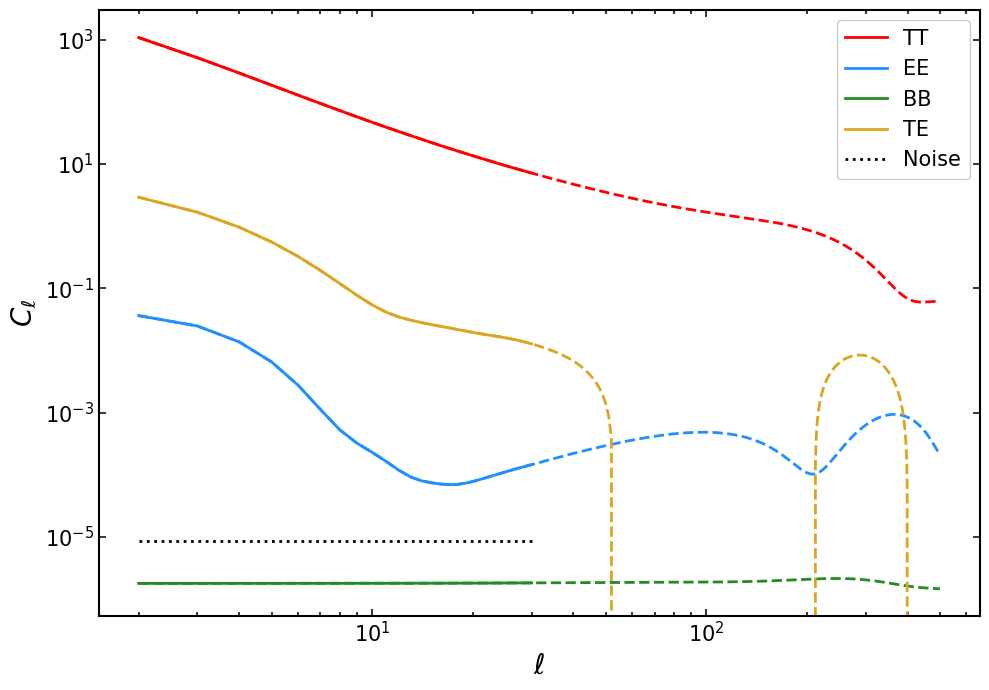

In [7]:
plt.plot(ell_full, full_spectrum[2:, 0], color = "C0", ls="--")
plt.plot(ell_full, full_spectrum[2:, 1], color = "C1", ls="--")
plt.plot(ell_full, full_spectrum[2:, 2], color = "C2", ls="--")
plt.plot(ell_full, full_spectrum[2:, 3], color = "C3", ls="--")

plt.plot(ell, fiducial_spectrum[2:, 0], label="TT", ls = "-", color = "C0")
plt.plot(ell, fiducial_spectrum[2:, 1], label="EE", ls = "-", color = "C1")
plt.plot(ell, fiducial_spectrum[2:, 2], label="BB", ls = "-", color = "C2")
plt.plot(ell, fiducial_spectrum[2:, 3], label="TE", ls = "-", color = "C3")

plt.plot(ell, noise_spectrum, label="Noise", ls = ":", color = "black")

plt.loglog()

plt.legend(loc = "upper right", frameon = True, framealpha = 1)

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.show()

In [11]:
file = "fiducial_gaussian_40fsky_1degbeam_1000sims.npy"
fiducial_gaussian = np.load(chi2s_folder + file)

file = "ideal_ptep_40fsky_1degbeam_1000sims.npy"
ideal_ptep = np.load(chi2s_folder + file)

file = "ideal_ptep_fsky_squared_40fsky_1degbeam_1000sims.npy"
ideal_ptep_fsky_squared = np.load(chi2s_folder + file)

file = "hl_40fsky_1degbeam_1000sims.npy"
hl_likelihood = np.load(chi2s_folder + file)

file = "offset_hl_40fsky_1degbeam_1000sims.npy"
ohl_likelihood = np.load(chi2s_folder + file)

file = "lollipop_no_offset_40fsky_1degbeam_1000sims.npy"
lollipop_no_offset = np.load(chi2s_folder + file)

file = "lollipop_40fsky_1degbeam_1000sims.npy"
lollipop = np.load(chi2s_folder + file)

In [18]:
colors = [
    # "darkviolet",
    "dodgerblue",
    "cyan",
    "forestgreen",
    "goldenrod",
    "red",
    "maroon",
]

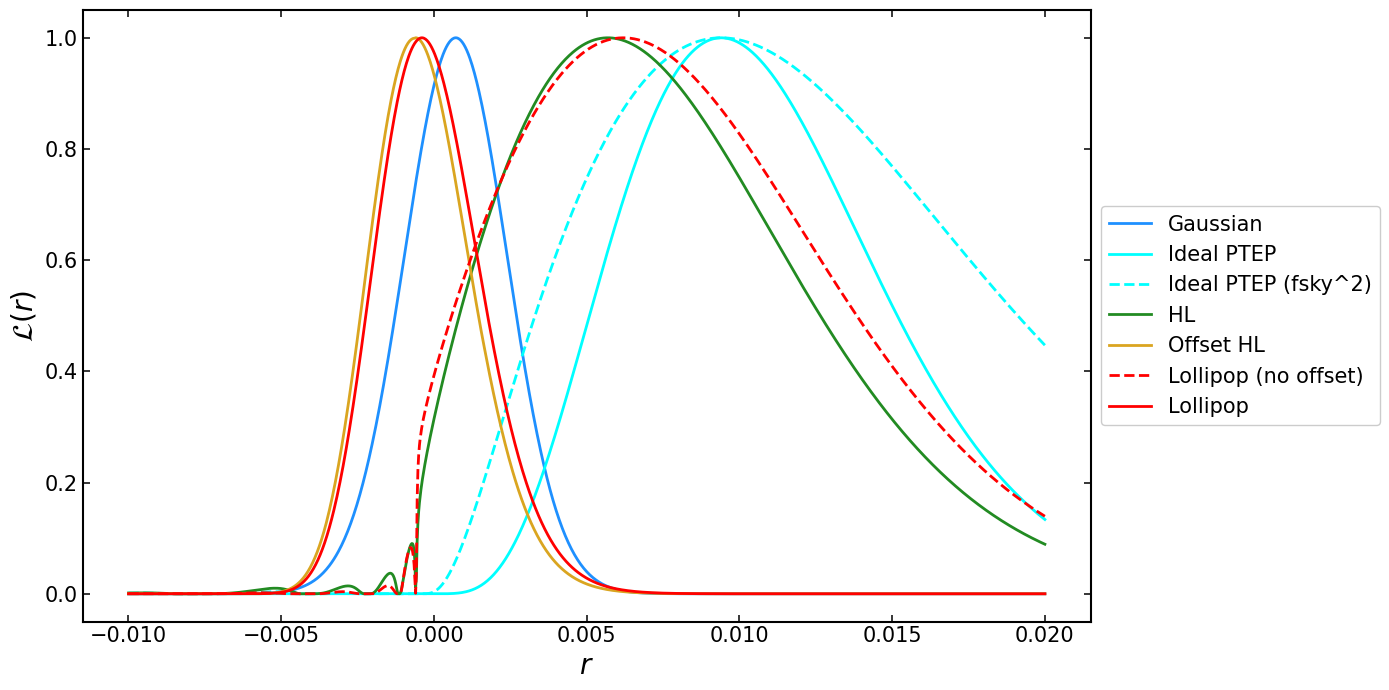

In [26]:
plt.figure(figsize=[14, 7])

plt.plot(r005s, np.exp(-0.5*np.mean(fiducial_gaussian, axis=1))/np.max(np.exp(-0.5*np.mean(fiducial_gaussian, axis=1))), label = "Gaussian", color=colors[0])

plt.plot(r005s, np.exp(-0.5*np.mean(ideal_ptep, axis=1))/np.max(np.exp(-0.5*np.mean(ideal_ptep, axis=1))), label = "Ideal PTEP", color=colors[1])

plt.plot(r005s, np.exp(-0.5*np.mean(ideal_ptep_fsky_squared, axis=1))/np.max(np.exp(-0.5*np.mean(ideal_ptep_fsky_squared, axis=1))), label = "Ideal PTEP (fsky^2)", color=colors[1], ls="--")

plt.plot(r005s, np.exp(-0.5*np.mean(hl_likelihood, axis=1))/np.max(np.exp(-0.5*np.mean(hl_likelihood, axis=1))), label = "HL", color=colors[2])

plt.plot(r005s, np.exp(-0.5*np.mean(ohl_likelihood, axis=1))/np.max(np.exp(-0.5*np.mean(ohl_likelihood, axis=1))), label = "Offset HL", color=colors[3])

plt.plot(r005s, np.exp(-0.5*np.mean(lollipop_no_offset, axis=1))/np.max(np.exp(-0.5*np.mean(lollipop_no_offset, axis=1))), label = "Lollipop (no offset)", color=colors[4], ls="--")

plt.plot(r005s, np.exp(-0.5*np.mean(lollipop, axis=1))/np.max(np.exp(-0.5*np.mean(lollipop, axis=1))), label = "Lollipop", color=colors[4])

plt.xlabel(r"$r$")
plt.ylabel(r"$\mathcal{L}(r)$")

plt.legend(loc = "center left", frameon = True, framealpha = 1, bbox_to_anchor=(1, 0.5))
plt.show()